<a href="https://colab.research.google.com/github/banshee0716/Financial-Big-Data-Analysis/blob/master/%E9%87%91%E8%9E%8D%E6%95%B8%E6%93%9A%E5%88%86%E6%9E%90W9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transformer part

In [19]:
# 第一個區塊：導入必要的套件
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 設定隨機種子
np.random.seed(42)
tf.random.set_seed(42)


In [20]:
# 定義 TFT 模型
class TemporalFusionTransformer(Model):
    def __init__(self, window_size, hidden_dim=64, num_heads=4):
        super(TemporalFusionTransformer, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.window_size = window_size

        # 時間嵌入層
        self.input_layer = layers.Input(shape=(window_size, 1))

        # LSTM 用於處理時間依賴
        self.lstm = layers.LSTM(hidden_dim, return_sequences=True)

        # Transformer 多頭注意力層
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)

        # 前饋神經網絡
        self.dense1 = layers.Dense(hidden_dim, activation="relu")
        self.dense2 = layers.Dense(1)  # 預測未來一天

    def call(self, inputs):
        x = self.lstm(inputs)
        attn_output = self.attention(x, x)
        x = layers.Add()([x, attn_output])
        x = self.dense1(x)
        x = layers.GlobalAveragePooling1D()(x)
        output = self.dense2(x)
        return output

In [21]:
# 定義 LSTM 模型
def create_lstm_model(window_size):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [22]:
# 數據準備函數
def download_stock_data(ticker="2330.TW", start="2020-01-01", end="2023-01-01"):
    df = yf.download(ticker, start=start, end=end)
    return df[['Close']].values

def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)


In [23]:
# 訓練和評估函數
def train_and_evaluate_models(data, window_size=20, train_ratio=0.8):
    # 數據標準化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # 創建數據集
    X, y = create_dataset(scaled_data, window_size)

    # 分割訓練與測試集
    train_size = int(len(X) * train_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    print(f"訓練集形狀: {X_train.shape}, 測試集形狀: {X_test.shape}")

    # 創建並訓練 LSTM 模型
    print("\n訓練 LSTM 模型...")
    lstm_model = create_lstm_model(window_size)
    lstm_history = lstm_model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # 創建並訓練 TFT 模型
    print("\n訓練 TFT 模型...")
    tft_model = TemporalFusionTransformer(window_size)
    tft_model.compile(optimizer='adam', loss='mean_squared_error')
    tft_history = tft_model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # 預測
    lstm_pred = lstm_model.predict(X_test)
    tft_pred = tft_model.predict(X_test)

    # 反標準化
    lstm_pred = scaler.inverse_transform(lstm_pred)
    tft_pred = scaler.inverse_transform(tft_pred)
    y_test_inv = scaler.inverse_transform(y_test)

    # 計算漲跌方向準確率
    def calculate_direction_accuracy(pred, real):
        pred_dir = np.where(pred[1:] > pred[:-1], 1, 0)
        real_dir = np.where(real[1:] > real[:-1], 1, 0)
        return np.mean(pred_dir == real_dir) * 100

    lstm_accuracy = calculate_direction_accuracy(lstm_pred, y_test_inv)
    tft_accuracy = calculate_direction_accuracy(tft_pred, y_test_inv)

    return {
        'data': data,
        'window_size': window_size,
        'train_size': train_size,
        'real_values': y_test_inv,
        'lstm': {
            'predictions': lstm_pred,
            'accuracy': lstm_accuracy,
            'history': lstm_history.history
        },
        'tft': {
            'predictions': tft_pred,
            'accuracy': tft_accuracy,
            'history': tft_history.history
        }
    }


In [24]:
# 繪圖函數
def plot_results(results):
    # 繪製預測結果比較圖
    plt.figure(figsize=(15, 7))

    # 實際值
    plt.plot(results['real_values'], label='Actual Price', color='blue')

    # LSTM 預測
    plt.plot(results['lstm']['predictions'],
             label=f'LSTM (Acc: {results["lstm"]["accuracy"]:.2f}%)',
             color='green', linestyle='--')

    # TFT 預測
    plt.plot(results['tft']['predictions'],
             label=f'TFT (Acc: {results["tft"]["accuracy"]:.2f}%)',
             color='red', linestyle=':')

    plt.title('Stock Price Prediction Comparison')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 繪製損失函數曲線
    plt.figure(figsize=(15, 7))
    plt.plot(results['lstm']['history']['loss'], label='LSTM Training Loss')
    plt.plot(results['lstm']['history']['val_loss'], label='LSTM Validation Loss')
    plt.plot(results['tft']['history']['loss'], label='TFT Training Loss')
    plt.plot(results['tft']['history']['val_loss'], label='TFT Validation Loss')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%***********************]  1 of 1 completed

下載股票數據...
開始訓練模型...
訓練集形狀: (571, 20, 1), 測試集形狀: (143, 20, 1)

訓練 LSTM 模型...
Epoch 1/50



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.2133 - val_loss: 0.0062
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0208 - val_loss: 0.0025
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0156 - val_loss: 0.0022
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0119 - val_loss: 0.0020
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0105 - val_loss: 0.0038
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0110 - val_loss: 0.0020
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0089 - val_loss: 0.0019
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0111 - val_loss: 0.0029
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0099 - val_loss: 0.0019
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0105 - val_loss: 0.0023
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0112 - val_loss: 0.0019
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0111 - val_l

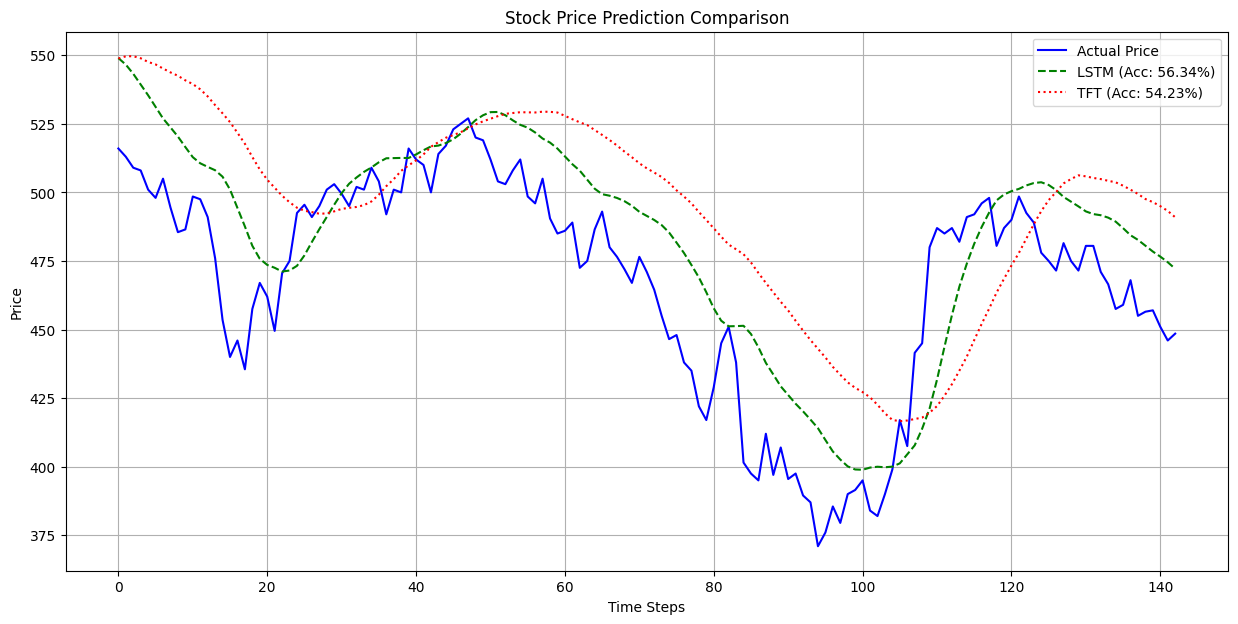

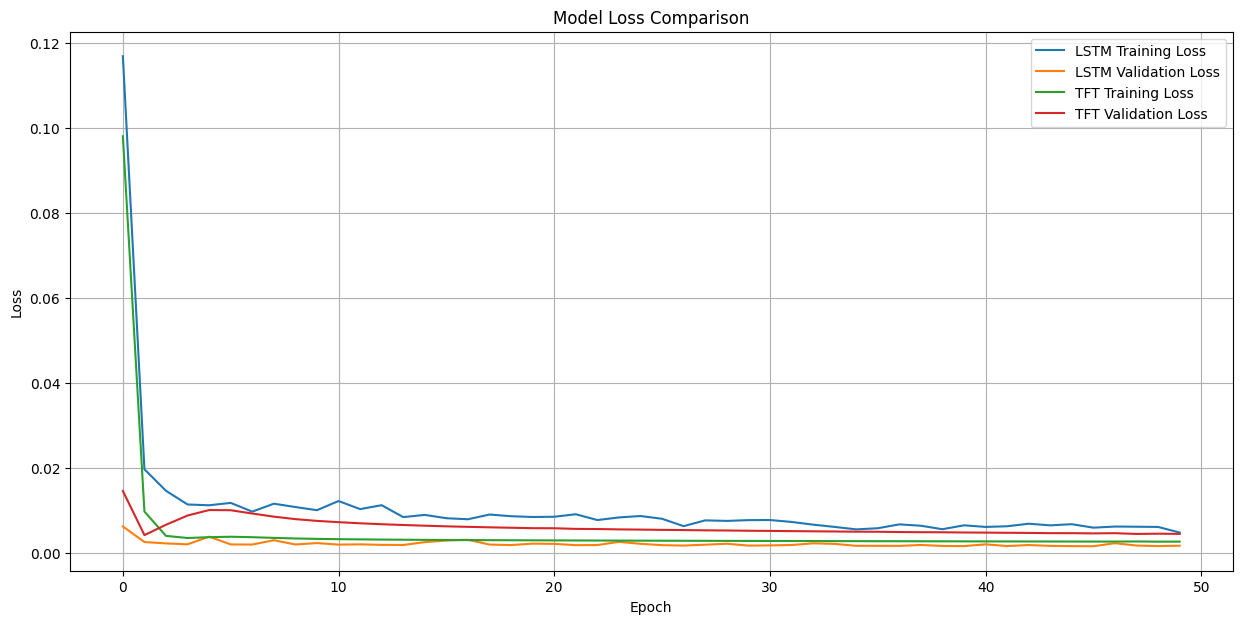

In [26]:
def main():
    # 下載數據
    print("下載股票數據...")
    data = download_stock_data()

    # 訓練和評估模型
    print("開始訓練模型...")
    results = train_and_evaluate_models(data)


    # 繪製結果
    plot_results(results)

if __name__ == "__main__":
    main()